In [15]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


/home/march/anaconda2/envs/py3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta', 'trace']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
import pymc3 as pm

## 1.

In [19]:
model = pm.Model()

In [20]:
with model:
    beta = pm.Beta('Beta', 1, 1)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1329.04it/s]


(array([ 45.,  58.,  59.,  58.,  52.,  42.,  39.,  43.,  46.,  58.]),
 array([ 0.00764617,  0.10664129,  0.20563642,  0.30463155,  0.40362668,
         0.5026218 ,  0.60161693,  0.70061206,  0.79960718,  0.89860231,
         0.99759744]),
 <a list of 10 Patch objects>)

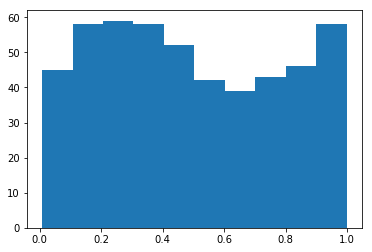

In [21]:
hist([t['Beta'] for t in trace.points()])

In [32]:
model = pm.Model()
with model:
    beta = pm.Beta('Beta', 50, 50)  # TODO: NUTS no funciona con 100, 100
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1269.58it/s]


(array([   4.,    8.,   37.,   42.,   82.,  120.,   99.,   75.,   19.,   14.]),
 array([ 0.33670238,  0.36616719,  0.39563199,  0.4250968 ,  0.4545616 ,
         0.48402641,  0.51349122,  0.54295602,  0.57242083,  0.60188563,
         0.63135044]),
 <a list of 10 Patch objects>)

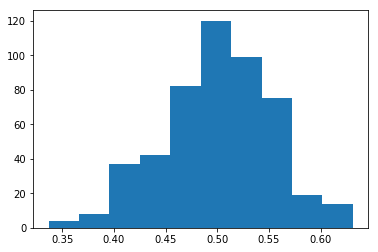

In [34]:
hist([t['Beta'] for t in trace.points()])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1261.71it/s]


(array([   3.,    2.,   10.,   20.,   36.,   48.,   50.,   67.,   88.,  176.]),
 array([ 0.46207478,  0.51581751,  0.56956024,  0.62330297,  0.6770457 ,
         0.73078843,  0.78453116,  0.83827389,  0.89201662,  0.94575935,
         0.99950208]),
 <a list of 10 Patch objects>)

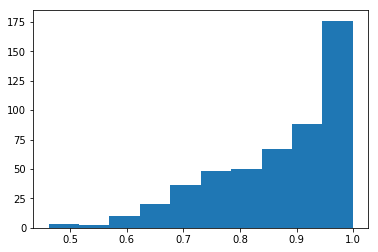

In [47]:
model = pm.Model()
with model:
    beta = pm.Beta('beta', 1, 1)
    tiradas = pm.Binomial('tiradas', n=6, p=beta, observed=6)
    trace = pm.sample()
hist(trace.beta)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1374.47it/s]


(array([   8.,   15.,   43.,   70.,  122.,  106.,   96.,   22.,   10.,    8.]),
 array([ 0.40109884,  0.42760641,  0.45411399,  0.48062156,  0.50712914,
         0.53363671,  0.56014428,  0.58665186,  0.61315943,  0.63966701,
         0.66617458]),
 <a list of 10 Patch objects>)

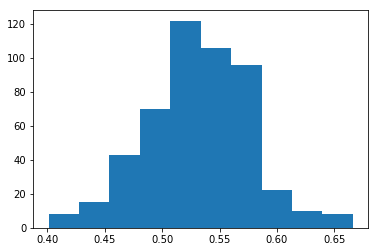

In [71]:
model = pm.Model()
with model:
    beta = pm.Beta('beta', 50, 50)  # TODO: cambiar a 100, 100 cuando sepamos como
    tiradas = pm.Binomial('tiradas', n=6, p=beta, observed=6)
    trace = pm.sample()
hist(trace.beta)

In [63]:
trace.point(10)

{'beta': 0.49665140461576607,
 'beta_logodds__': -0.013394581798884891,
 'tiradas': 4}

## 2.

#### Caso Uniforme

In [79]:
model = pm.Model()
with model:
    theta = pm.Beta('theta', 1, 1)
    tiradas = pm.Binomial('tiradas', p=theta, n=6, observed=6)
    trace = pm.sample()
    MAP = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1286.77it/s]
logp = -0.0023631, ||grad|| = 0.0023627: 100%|██████████| 20/20 [00:00<00:00, 2461.52it/s]  


In [82]:
print('MAP Estimate para beta(1, 1): {}'.format(MAP['theta']))

MAP Estimate para beta(1, 1): 0.9999984620831801


In [83]:
print('Media para beta(1, 1): {}'.format(mean(trace.theta)))

Media para beta(1, 1): 0.8730561113059758


#### Caso Honesta

In [84]:
model = pm.Model()
with model:
    theta = pm.Beta('theta', 50, 50)  # TODO
    tiradas = pm.Binomial('tiradas', p=theta, n=6, observed=6)
    trace = pm.sample()
    MAP = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1307.56it/s]
logp = -2.0846, ||grad|| = 3: 100%|██████████| 6/6 [00:00<00:00, 1859.04it/s]


In [85]:
print('MAP Estimate para beta(50, 50): {}'.format(MAP['theta']))

MAP Estimate para beta(50, 50): 0.5288461537406147


In [86]:
print('Media para beta(50, 50): {}'.format(mean(trace.theta)))

Media para beta(50, 50): 0.530568275863577


## 3.

#### Caso uniforme

In [89]:
model = pm.Model()
with model:
    theta = pm.Beta('theta', 1, 1)
    dato = pm.Binomial('dato', p=theta, n=6, observed=6)
    post = pm.Binomial('post', p=theta, n=6)
    trace = pm.sample()

Assigned NUTS to theta_logodds__
Assigned Metropolis to post
100%|██████████| 1000/1000 [00:01<00:00, 596.42it/s]


In [90]:
trace.varnames

['theta_logodds__', 'post', 'theta']

(array([  11.,    0.,   18.,    0.,    0.,   44.,    0.,  153.,    0.,  274.]),
 array([ 2. ,  2.4,  2.8,  3.2,  3.6,  4. ,  4.4,  4.8,  5.2,  5.6,  6. ]),
 <a list of 10 Patch objects>)

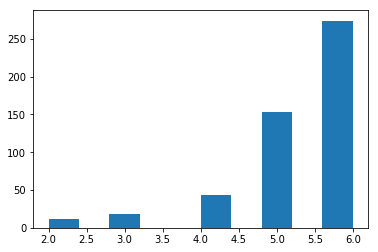

In [91]:
hist(trace.post)

#### Caso honesto 

In [92]:
model = pm.Model()
with model:
    theta = pm.Beta('theta', 50, 50)
    dato = pm.Binomial('dato', p=theta, n=6, observed=6)
    post = pm.Binomial('post', p=theta, n=6)
    trace = pm.sample()

Assigned NUTS to theta_logodds__
Assigned Metropolis to post
100%|██████████| 1000/1000 [00:01<00:00, 655.07it/s]


(array([   8.,   23.,    0.,  147.,    0.,  126.,  134.,    0.,   48.,   14.]),
 array([ 0. ,  0.6,  1.2,  1.8,  2.4,  3. ,  3.6,  4.2,  4.8,  5.4,  6. ]),
 <a list of 10 Patch objects>)

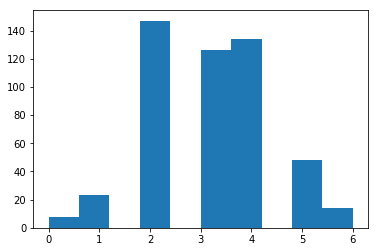

In [93]:
hist(trace.post)